In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# Projectile trajectory optimization

We demonstrate how to differentiate trough an ODE solver using `forward` mode differentiation, by building the Jacobian of the integration function.

In [2]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
from jwave.ode import semi_implicit_euler
from jax import value_and_grad, jacfwd, jit
from functools import partial
from tqdm import tqdm
from jax.experimental import optimizers

In [3]:
# Setup
p0 = jnp.array([0.0, 0.0])  # m
v0 = jnp.array([3., 3])  # m/s
g = 9.81

dt = 0.01
t_end = 1
output_steps = (jnp.arange(0, t_end, dt) / dt).round()
p_target = jnp.array([4., 1.])

f_1 = lambda v, t: v
f_2 = lambda p, t: 0.5*jnp.array([0.,-g])

def trajectory_endpoint(v):
    p, _ = semi_implicit_euler(f_1, f_2, p0, v, dt, output_steps, timestep_correction=1.0)
    return p[-1]

def loss(p):
    return jnp.sum((p_target - p)**2)

@jit
def loss_with_grad(v):
    lossval, loss_gradient = value_and_grad(loss)(trajectory_endpoint(v))
    J = jacfwd(trajectory_endpoint)(v)
    gradient = loss_gradient @ J
    return lossval, gradient

In [4]:
v = v0

losshistory = []
vx_history = []
vy_history = []
trajectory_history = []

init_fun, update_fun, get_params = optimizers.adam(0.03)
opt_state = init_fun(v)

@jit
def update(opt_state):
    v = get_params(opt_state)
    lossval, gradient = loss_with_grad(v)
    return lossval, update_fun(k, gradient, opt_state)

for k in tqdm(range(100)):
    lossval, opt_state = update(opt_state)
    
    # For logging
    v = get_params(opt_state)
    vx_history.append(v[0])
    vy_history.append(v[1])
    losshistory.append(lossval)
    traj, _ = semi_implicit_euler(f_1, f_2, p0, v, dt, output_steps, timestep_correction=1.0)
    trajectory_history.append(traj)
    
v = get_params(opt_state)

100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


In [5]:
p_start, _ = semi_implicit_euler(f_1, f_2, p0, v0, dt, output_steps, timestep_correction=1.0)
p, _ = semi_implicit_euler(f_1, f_2, p0, v, dt, output_steps, timestep_correction=1.0)

Text(0.5, 0, 'Iteration')

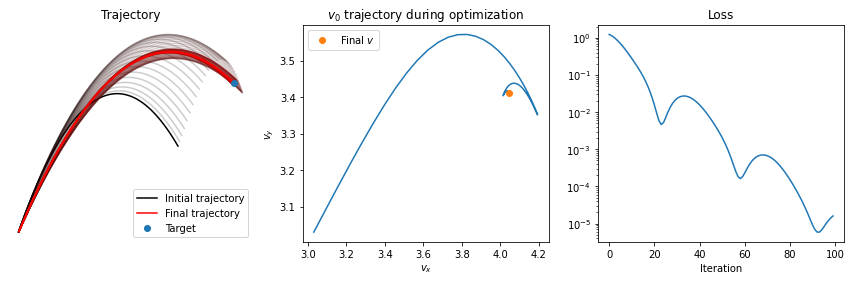

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(p_start[:, 0], p_start[:, 1], label="Initial trajectory", color="black")
for traj, num in zip(trajectory_history, range(len(trajectory_history))):
    ax[0].plot(traj[:, 0], traj[:, 1], alpha= 0.2, color=((num/100)**1,0.,0.))
ax[0].plot(p[:, 0], p[:, 1], label="Final trajectory", color="red")
ax[0].plot(p_target[0],p_target[1],'o',label="Target")
ax[0].legend()
ax[0].axis("off")
ax[0].set_title("Trajectory")

ax[1].plot(vx_history, vy_history)
ax[1].set_title("$v_0$ trajectory during optimization")
ax[1].set_xlabel("$v_x$")
ax[1].set_ylabel("$v_y$")
ax[1].plot(v[0],v[1],'o',label="Final $v$")
ax[1].legend()

ax[2].plot(losshistory)
ax[2].set_title("Loss")
ax[2].set_yscale("log")
ax[2].set_xlabel("Iteration")